# Indigenous Trees of Seattle

A look at some of the indigenous trees of Seattle.

## Setup

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Here we load our data set and filter out a few records.

dftrees = pd.read_csv('data/trees_of_seattle.csv', sep='|')
original_count = len(dftrees)

# Filtering out a few trees that are way outside the city range (which causes the maps to render funny).
dftrees = dftrees[dftrees['x'] > 1245000]
dftrees = dftrees[dftrees['y'] < 275000]

with open('data/trees_of_seattle.csv.metadata.json') as fin:
    dftrees_metadata_raw = fin.read()
    dftrees_metadata = json.loads(dftrees_metadata_raw)

print(f'Metadata for trees_of_seattle.csv: {repr(dftrees_metadata)}')
print(f'Discarded {original_count - len(dftrees)} out-of-bounds records. Final count {len(dftrees)}')

del dftrees_metadata_raw
del original_count

Metadata for trees_of_seattle.csv: {'version': '4', 'record_count': 198772, 'discarded_record_count': 55938, 'discarded_nonliving_trees_record_count': 55215, 'discarded_unknown_trees_record_count': 723}
Discarded 0 out-of-bounds records. Final count 198772


In [3]:
# Split up the trees dataset into indigenous and non-indigenous sets.

dftrees_ind = dftrees[dftrees['indigenous']]
dftrees_non = dftrees[~dftrees['indigenous']]

print(f'Indigenous     {len(dftrees_ind):6} ({len(dftrees_ind) / len(dftrees) * 100:4.1f}%)')
print(f'Non-indigenous {len(dftrees_non):6} ({len(dftrees_non) / len(dftrees) * 100:4.1f}%)')

Indigenous      14166 ( 7.1%)
Non-indigenous 184606 (92.9%)


In [4]:
# Plot the location of specific species records in the city.

def plot_trees(title, dfs, legend_texts, primary_size=.25):
    dftrees_bg = dftrees
    for df in dfs:
        dftrees_bg = dftrees_bg[~dftrees_bg['objectid'].isin(df['objectid'])]

    fig, ax = plt.subplots(figsize=(12, 12))  # x-dimension gets "forgotten" after set_aspect().
    
    def scale_formatter(value, tick_number):
        return f'{value / 1_000_000.0:.2f}'
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(scale_formatter))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(scale_formatter))
    
    ax.scatter(dftrees_bg['x'], dftrees_bg['y'], s=.25, color='#DDD', label='Other')

    for df, legend_text in zip(dfs, legend_texts):
        dftrees_fg = dftrees[dftrees['objectid'].isin(df['objectid'])]
        ax.scatter(dftrees_fg['x'], dftrees_fg['y'], s=primary_size, label=legend_text)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Longitudinal Position\n(Millions of Feet)')
    ax.set_ylabel('Latitudinal Position\n(Millions of Feet)')
    ax.set_title(title)
    ax.legend(scatterpoints=1, markerscale=4, title='Legend')
    
    plt.show()

## Overview

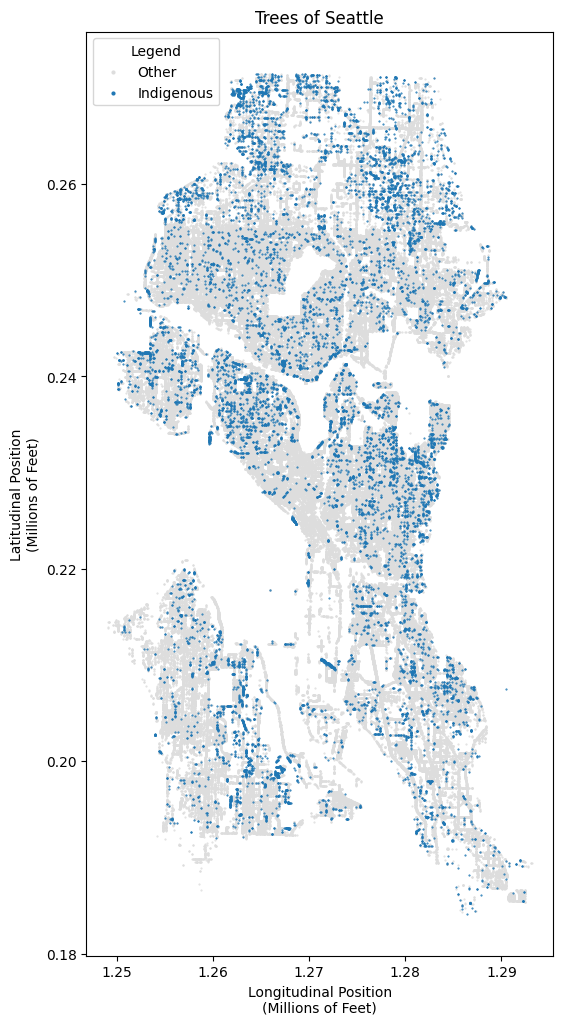

In [5]:
# Plot the location of trees in the city.

plot_trees('Trees of Seattle', [dftrees_ind], ['Indigenous'])

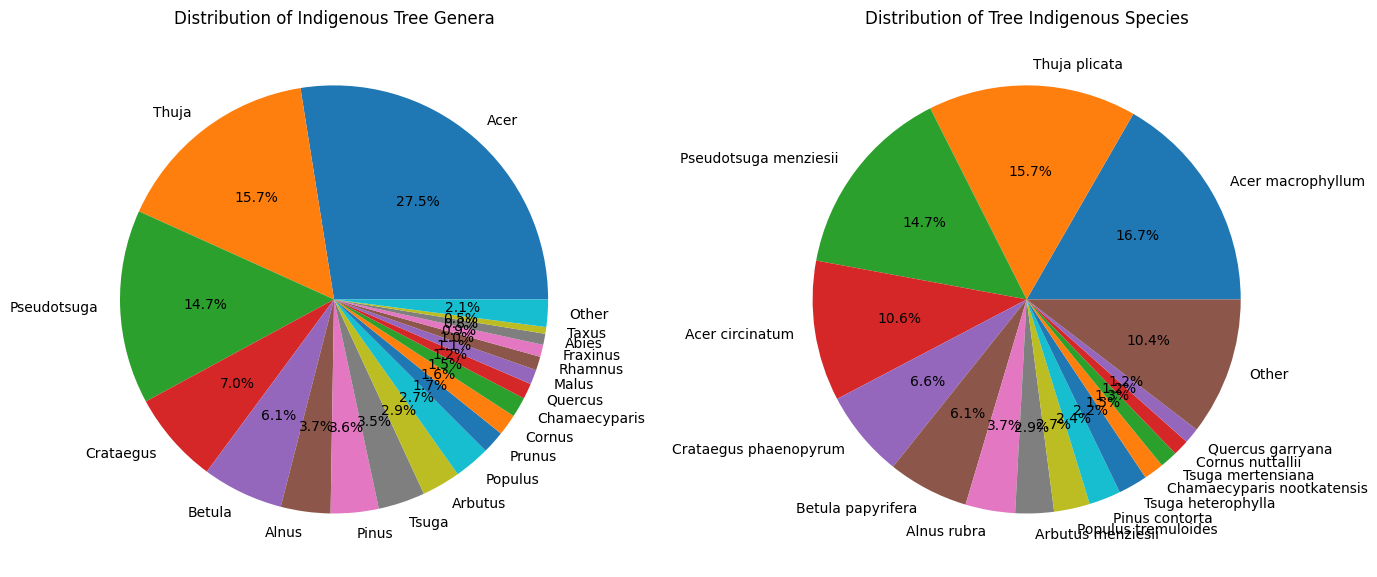

In [6]:
# Show the distribution of the various indigenous genera and species in Seattle.

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

def plot_genera(ax, cutoff_fraction):
    indigenous_counts = dftrees_ind['genus'].value_counts()
    
    cum_fractions = (indigenous_counts / indigenous_counts.sum()).cumsum()
    before_cutoff = indigenous_counts[cum_fractions < cutoff_fraction]
    after_cutoff = indigenous_counts[cum_fractions >= cutoff_fraction]
    others = pd.Series([after_cutoff.sum()], index=['Other'])

    result_counts = pd.concat([before_cutoff, others])

    result_counts.plot(
        kind ='pie',
        autopct='%1.1f%%',
        legend=False,
        labels=result_counts.index,
        ax=ax,
    )

    ax.set_title('Distribution of Indigenous Tree Genera')
    
def plot_species(df, cutoff_fraction=0.90, title='Title', ax=None):
    indigenous_counts = df['scientificname'].value_counts()
    
    cum_fractions = (indigenous_counts / indigenous_counts.sum()).cumsum()
    before_cutoff = indigenous_counts[cum_fractions < cutoff_fraction]
    after_cutoff = indigenous_counts[cum_fractions >= cutoff_fraction]
    others = pd.Series([after_cutoff.sum()], index=['Other'])

    result_counts = before_cutoff
    if len(after_cutoff) > 0:
        result_counts = pd.concat([result_counts, others])

    axresult = result_counts.plot(
        kind ='pie',
        autopct='%1.1f%%',
        legend=False,
        labels=result_counts.index,
        ax=ax,
    )

    axresult.set_ylabel('')
    axresult.set_title(title)


plot_genera(axes[0], 0.98)
plot_species(dftrees_ind, cutoff_fraction=0.90, title='Distribution of Tree Indigenous Species', ax=axes[1])

plt.tight_layout()
plt.show()

# TODO - Clean up percents.


## Genus Acer - The Maples

In [7]:
dfacer_ind = dftrees_ind[dftrees_ind['genus'] == 'Acer']
print('Total Trees in Genus Acer:', dfacer_ind['objectid'].count())
print()
print(dfacer_ind['scientificname'].value_counts())

Total Trees in Genus Acer: 3897

scientificname
Acer macrophyllum    2365
Acer circinatum      1502
Acer glabrum           30
Name: count, dtype: int64


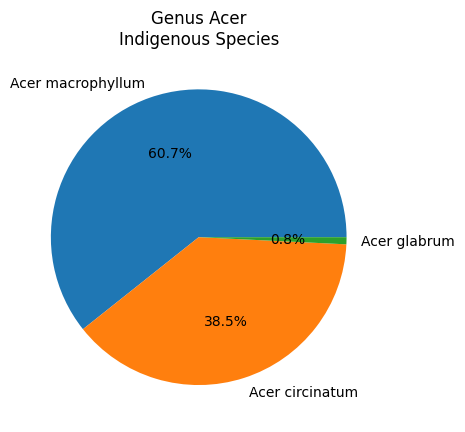

In [8]:
plot_species(dfacer_ind, cutoff_fraction=float('inf'), title='Genus Acer\nIndigenous Species')

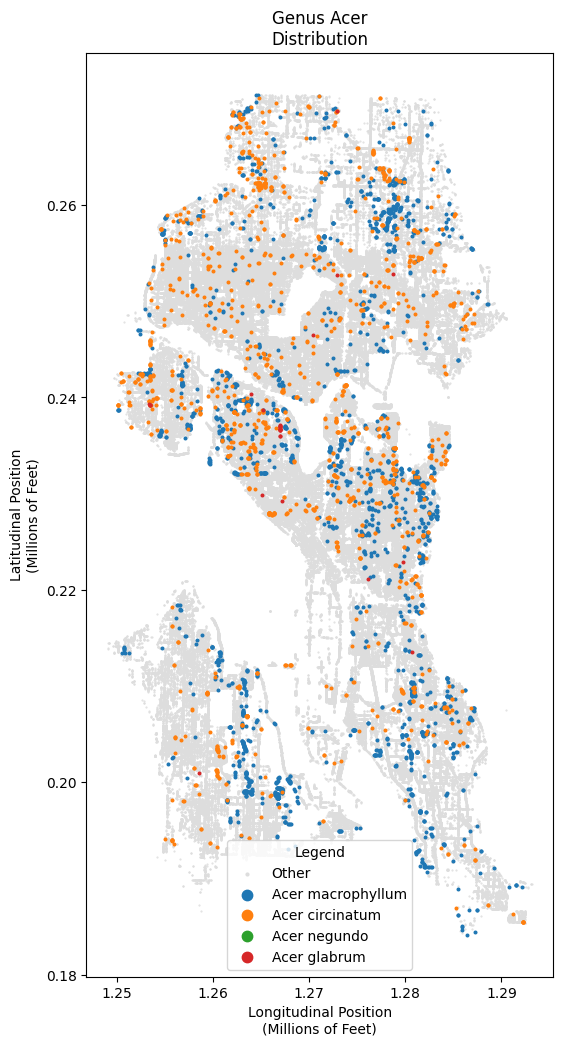

In [9]:
dfacer_macro = dfacer_ind[dfacer_ind['scientificname'] == 'Acer macrophyllum']
dfacer_circ = dfacer_ind[dfacer_ind['scientificname'] == 'Acer circinatum']
dfacer_neg = dfacer_ind[dfacer_ind['scientificname'] == 'Acer negundo']
dfacer_glab = dfacer_ind[dfacer_ind['scientificname'] == 'Acer glabrum']

plot_trees(
    'Genus Acer\nDistribution',
    [dfacer_macro, dfacer_circ, dfacer_neg, dfacer_glab],
    ['Acer macrophyllum', 'Acer circinatum', 'Acer negundo', 'Acer glabrum'],
    primary_size=3.5,
)


## Acer macrophyllum - Bigleaf Maple, Oregon Maple

<p>
    <a href="./media/acer_macrophyllum/Acer_macrophyllum_kz06.jpg">
        <img src="./media/acer_macrophyllum/Acer_macrophyllum_kz06.jpg" alt="Big Leaf Maple Bark" width="180" />
        <!-- Krzysztof Ziarnek, Kenraiz (2020), [https://commons.wikimedia.org/wiki/File:Acer_macrophyllum_kz06.jpg](https://commons.wikimedia.org/wiki/File:Acer_macrophyllum_kz06.jpg), CC BY-SA 4.0 -->
    </a>
    <a href="./media/acer_macrophyllum/Acer_macrophyllum_1199.jpg">
        <img src="./media/acer_macrophyllum/Acer_macrophyllum_1199.jpg" alt="Big Leaf Maple Leaves" width="300" />
        <!-- Tony Perodeau (2006), [https://commons.wikimedia.org/wiki/File:Acer_macrophyllum_1199.jpg?uselang=en](https://commons.wikimedia.org/wiki/File:Acer_macrophyllum_1199.jpg?uselang=en), Public Domain -->
    </a>
</p>
<p>
    <a href="./media/acer_macrophyllum/Bigleaf_maple_(Acer_macrophyllum)_closeup_of_flowers.jpg">
        <img src="./media/acer_macrophyllum/Bigleaf_maple_(Acer_macrophyllum)_closeup_of_flowers.jpg" alt="Big Leaf Maple Flowers" width="300" />
        <!-- Kollibri1969 (2024), [https://commons.wikimedia.org/wiki/File:Bigleaf_maple_(Acer_macrophyllum)_closeup_of_flowers.jpg](https://commons.wikimedia.org/wiki/File:Bigleaf_maple_(Acer_macrophyllum)_closeup_of_flowers.jpg), CC BY-SA 4.0 -->
    </a>
    <a href="./media/acer_macrophyllum/Acer_macrophyllum_3158.jpg">
        <img src="./media/acer_macrophyllum/Acer_macrophyllum_3158.jpg" alt="Big Leaf Maple Seeds" width="300" />
        <!-- Walter Siegmund (2004), [https://commons.wikimedia.org/wiki/File:Acer_macrophyllum_3158.jpg](https://commons.wikimedia.org/wiki/File:Acer_macrophyllum_3158.jpg), CC BY-SA 3.0 -->
    </a>
</p>

### Characteristics

* Height: 100 ft
* Canopy: 50 ft
* Reproduction:
    - Angiosperm
    - Hermaphroditic
        - Blooms in Spring (April to May)
    - Pollinated by Insects and Wind
    - Produces Double Samara Fruits ("Helicopters")

### Fun Facts

* Maple syrup can be made from its sap, just like the Sugar Maple!

### References

* [Acer macrophyllum (Wikipedia)](https://en.wikipedia.org/wiki/Acer_macrophyllum)
* [WSU PNW - Washington State University NorthWest Plants Database system](https://pnwplants.wsu.edu/PlantDisplay.aspx?PlantID=7)
* [Acer macrophyllum (Burke Herbarium Image Collection)](https://burkeherbarium.org/imagecollection/taxon.php?Taxon=Acer+macrophyllum)



## Acer circinatum - Vine Maple

<p>
    <a href="./media/acer_circinatum/Acer_circinatum_1.jpg">
        <img src="./media/acer_circinatum/Acer_circinatum_1.jpg" alt="Acer circinatum Leaves" width="160" />
    </a>
    <a href="./media/acer_circinatum/Acer_circinatum_in_Hackfalls_Arboretum_(1).jpg">
        <img src="./media/acer_circinatum/Acer_circinatum_in_Hackfalls_Arboretum_(1).jpg" alt="Acer circinatum Bark" width="180" />
    </a>
    <a href="./media/acer_circinatum/Vine_Maple_near_Deer_Creek_-_Ryan_Franklin_(11409292685).jpg">
        <img src="./media/acer_circinatum/Vine_Maple_near_Deer_Creek_-_Ryan_Franklin_(11409292685).jpg" alt="Vine Maple in the Fall" width="400" />
    </a>
</p>
<p>
    <a href="./media/acer_circinatum/Acer_circinatum_ÖBG_2012-05-13_03.jpg">
        <img src="./media/acer_circinatum/Acer_circinatum_ÖBG_2012-05-13_03.jpg" alt="Acer circinatum Flowers" width="180" />
    </a>
    <a href="./media/acer_circinatum/Acer_circinatum_9468.JPG">
        <img src="./media/acer_circinatum/Acer_circinatum_9468.JPG" alt="Acer circinatum Fruits" width="300" />
    </a>
</p>

### Characteristics

* Height: 26 ft
* Many Stemmed Base
    - Branches are from 1-4 in
* Lifespan: 80-90 year
* Reproduction:
    - Angiosperm
    - Hermaphroditic?
        - Blooms in ?
    - Pollinated by Insects and Wind
    - Produces Double Winged Sarama Fruits ("Helicopter")

### Fun Facts

* Maple syrup can be made from its sap, just like the Sugar Maple!

### References

* [Acer circinatum (Wikipedia)](https://en.wikipedia.org/wiki/Acer_circinatum)
* [Native Plants PNW](https://nativeplantspnw.com/vine-maple-acer-circinatum/)
* [Acer circinatum (Burke Herbarium Image Collection)](https://burkeherbarium.org/imagecollection/taxon.php?Taxon=Acer%20circinatum)
* Ryan Franklin (2013), [`https://commons.wikimedia.org/wiki/File:Vine_Maple_near_Deer_Creek_-_Ryan_Franklin_(11409292685).jpg`](https://commons.wikimedia.org/wiki/File:Vine_Maple_near_Deer_Creek_-_Ryan_Franklin_\(11409292685\).jpg), CC BY 2.0
* Krzysztof Golik (2017), [`https://commons.wikimedia.org/wiki/File:Acer_circinatum_in_Hackfalls_Arboretum_(1).jpg`](https://commons.wikimedia.org/wiki/File:Acer_circinatum_in_Hackfalls_Arboretum_\(1\).jpg), CC BY-SA 4.0
* El Grafo (2012), [`https://commons.wikimedia.org/wiki/File:Acer_circinatum_%C3%96BG_2012-05-13_03.jpg`](https://commons.wikimedia.org/wiki/File:Acer_circinatum_%C3%96BG_2012-05-13_03.jpg), CC BY-SA 3.0
* Walter Siegmund (2008), [`https://commons.wikimedia.org/wiki/File:Acer_circinatum_9468.JPG`](https://commons.wikimedia.org/wiki/File:Acer_circinatum_9468.JPG), CC BY-SA 3.0
* Thayne Tuason (2011), [`https://commons.wikimedia.org/wiki/File:Acer_circinatum_1.jpg`](https://commons.wikimedia.org/wiki/File:Acer_circinatum_1.jpg), CC BY-SA 4.0

## Scratchpad

* What's up with the section on the right with high rated trees?
* Condition rating of indigenous trees vs non-indigenous?
* Average condition rating breakdown by genus/species?
* A count of the the species in each species highlight section?

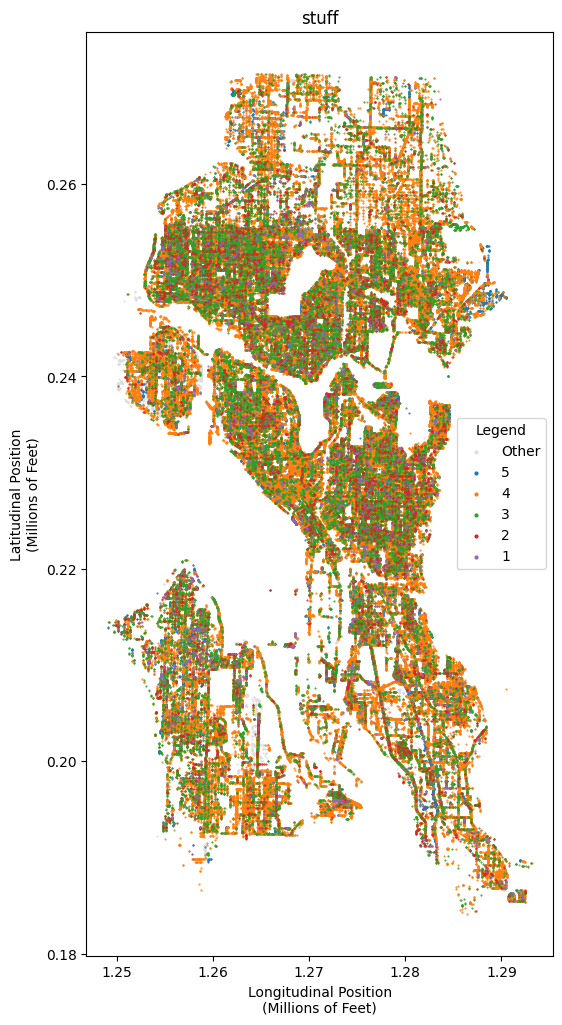

In [10]:
plot_trees('stuff', [
    dftrees[dftrees['conditionrating'] == 5],
    dftrees[dftrees['conditionrating'] == 4],
    dftrees[dftrees['conditionrating'] == 3],
    dftrees[dftrees['conditionrating'] == 2],
    dftrees[dftrees['conditionrating'] == 1],
], [
    '5',
    '4',
    '3',
    '2',
    '1',
   ])

In [11]:
print(dftrees_ind.groupby('scientificname')['conditionrating'].mean().sort_values(ascending=False))

scientificname
Callitropsis nootkatensis        4.285714
Picea sitchensis                 4.033333
Taxus brevifolia                 4.028571
Chamaecyparis nootkatensis       4.023474
Rubus ursinus                    4.000000
Myrica californica               4.000000
Crataegus douglasii              3.981818
Pinus contorta var. latifolia    3.947368
Acer glabrum                     3.933333
Tsuga mertensiana                3.922652
Cornus sericea                   3.912281
Thuja plicata                    3.895343
Pinus contorta                   3.873156
Abies grandis                    3.867470
Pseudotsuga menziesii            3.857913
Pinus monticola                  3.847458
Holodiscus discolor              3.846154
Amelanchier alnifolia            3.803571
Populus tremuloides              3.800000
Juniperus scopulorum             3.777778
Salix scouleriana                3.757576
Acer circinatum                  3.756868
Abies amabilis                   3.750000
Physocarpus capitat

In [12]:
dfgoodtrees = dftrees_non['scientificname'].value_counts()[:520]
dfgoodtrees = [x for x in dfgoodtrees.index.to_list() if ' x ' not in x and '"' not in x and ' var' not in x and '\'' not in x and '‘' not in x and '`' not in x and '/' not in x and ' TM' not in x and '(' not in x]
dfmytrees = dftrees_non[dftrees_non['scientificname'].isin(dfgoodtrees)]
print(dfmytrees.groupby('scientificname')['conditionrating'].mean().sort_values(ascending=False))

scientificname
Magnolia grandiflora Samuel So    4.500000
Ulmus rubra                       4.285714
Magnolia grandiflora Majestic     4.277778
Euonymus japonica                 4.250000
Ilex crenata                      4.192308
Acer buergerianum                 4.177632
Tilia heterophylla                4.176471
Cornus alternifolia               4.166667
Quercus robur f fastigiata        4.166667
Platycladus orientalis            4.158537
Eriobotrya japonica               4.142857
Acer triflorum                    4.117647
Umbellularia californica          4.117647
Acer saccharum ssp. Grandident    4.109756
Acer cappadocicum                 4.105263
Magnolia denudata                 4.095238
Sciadopitys virticillata          4.090909
Quercus imbricaria                4.090909
Juniperus chinensis               4.086957
Castanea dentata                  4.076923
Ulmus chenmoui                    4.076923
Quercus chrysolepis               4.076923
Cedrus deodara                    4.073

In [13]:
dftrees_non[dftrees_non['scientificname'] == 'Bamboo sp.']

,objectid,scientificname,genus,local,indigenous,conditionrating,x,y
184053,72358940,Bamboo sp.,Bamboo,False,False,5.0,1.267968e+06,261147.562815


In [14]:
# points -> "bin" -> stats for trees in the bin (this could be a count, or avg rating or something) -> plot bins into a map
dftrees[:1]

,objectid,scientificname,genus,local,indigenous,conditionrating,x,y
0,72121582,Cercidiphyllum japonicum,Cercidiphyllum,False,False,3.0,1.267773e+06,226716.000092


(1249044.03202781, 1293142.52717696) (184160.826480627, 271491.940426052) 587.9799353219972


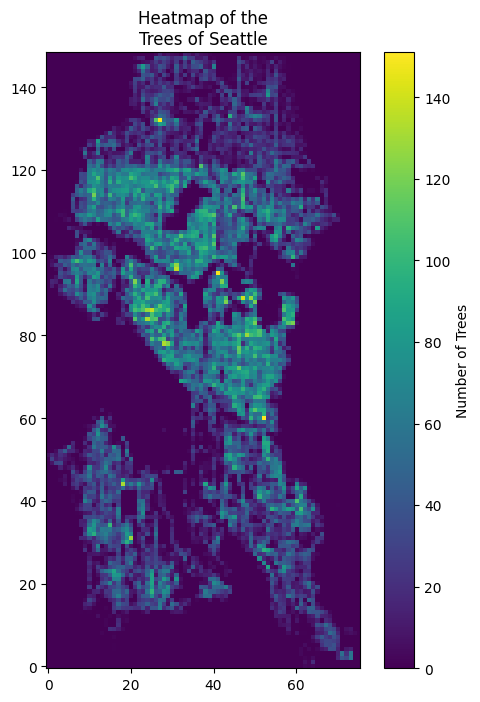

In [15]:
x_min, x_max = dftrees['x'].min().item(), dftrees['x'].max().item()
y_min, y_max = dftrees['y'].min().item(), dftrees['y'].max().item()

x_extent = x_max - x_min
y_extent = y_max - y_min

n_bins_horizontal = 75
bin_dim = x_extent / n_bins_horizontal  # feet per bin

print((x_min, x_max), (y_min, y_max), bin_dim)

dfbins = dftrees.copy()
dfbins['xbin'] = np.floor(((dfbins['x'] - x_min) / bin_dim)).astype(np.int64)
dfbins['ybin'] = np.floor(((dfbins['y'] - y_min) / bin_dim)).astype(np.int64)

heatmap_data = dfbins.groupby(['ybin', 'xbin']).size().unstack(fill_value=0)

plt.figure(figsize=(6, 8))
plt.imshow(heatmap_data, origin='lower', cmap='viridis')

# Add labels
plt.colorbar(label='Number of Trees')
plt.title('Heatmap of the\nTrees of Seattle')

plt.show()

(1249044.03202781, 1293142.52717696) (184160.826480627, 271491.940426052) 587.9799353219972


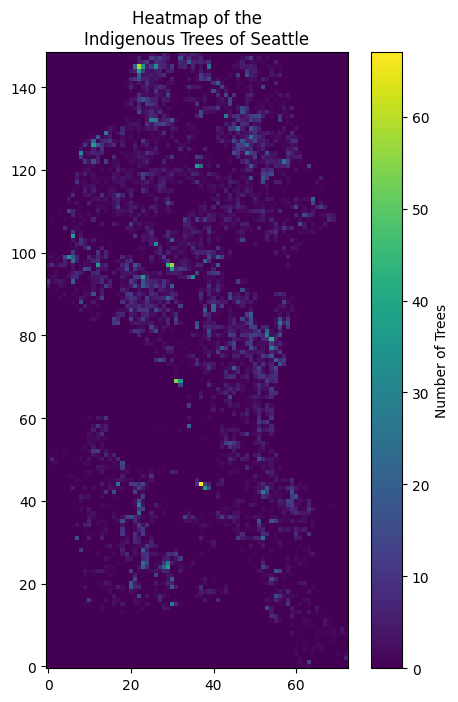

In [16]:
x_min, x_max = dftrees['x'].min().item(), dftrees['x'].max().item()
y_min, y_max = dftrees['y'].min().item(), dftrees['y'].max().item()

x_extent = x_max - x_min
y_extent = y_max - y_min

n_bins_horizontal = 75
bin_dim = x_extent / n_bins_horizontal  # feet per bin

print((x_min, x_max), (y_min, y_max), bin_dim)

dfbins = dftrees_ind.copy()
dfbins['xbin'] = np.floor(((dfbins['x'] - x_min) / bin_dim)).astype(np.int64)
dfbins['ybin'] = np.floor(((dfbins['y'] - y_min) / bin_dim)).astype(np.int64)

heatmap_data = dfbins.groupby(['ybin', 'xbin']).size().unstack(fill_value=0)

plt.figure(figsize=(6, 8))
plt.imshow(heatmap_data, origin='lower', cmap='viridis')

# Add labels
plt.colorbar(label='Number of Trees')
plt.title('Heatmap of the\nIndigenous Trees of Seattle')

plt.show()

(1249044.03202781, 1293142.52717696) (184160.826480627, 271491.940426052) 367.4874595762483


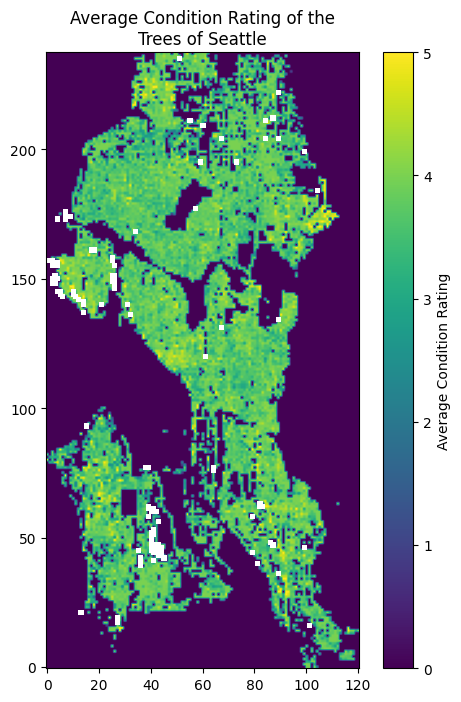

In [17]:
x_min, x_max = dftrees['x'].min().item(), dftrees['x'].max().item()
y_min, y_max = dftrees['y'].min().item(), dftrees['y'].max().item()

x_extent = x_max - x_min
y_extent = y_max - y_min

n_bins_horizontal = 120
bin_dim = x_extent / n_bins_horizontal  # feet per bin

print((x_min, x_max), (y_min, y_max), bin_dim)

dfbins = dftrees.copy()
dfbins['xbin'] = np.floor(((dfbins['x'] - x_min) / bin_dim)).astype(np.int64)
dfbins['ybin'] = np.floor(((dfbins['y'] - y_min) / bin_dim)).astype(np.int64)

heatmap_data = dfbins.groupby(['ybin', 'xbin'])['conditionrating'].mean().unstack(fill_value=0)

plt.figure(figsize=(6, 8))
plt.imshow(heatmap_data, origin='lower', cmap='viridis')

# Add labels
plt.colorbar(label='Average Condition Rating')
plt.title('Average Condition Rating of the\nTrees of Seattle')

plt.show()

(1249044.03202781, 1293142.52717696) (184160.826480627, 271491.940426052) 367.4874595762483


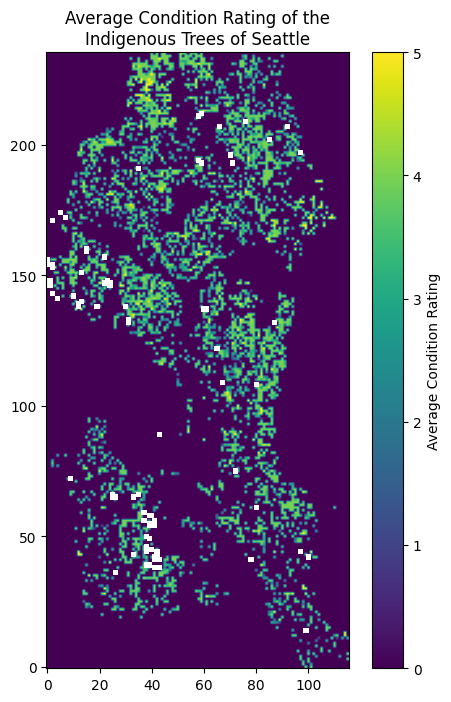

In [18]:
x_min, x_max = dftrees['x'].min().item(), dftrees['x'].max().item()
y_min, y_max = dftrees['y'].min().item(), dftrees['y'].max().item()

x_extent = x_max - x_min
y_extent = y_max - y_min

n_bins_horizontal = 120
bin_dim = x_extent / n_bins_horizontal  # feet per bin

print((x_min, x_max), (y_min, y_max), bin_dim)

dfbins = dftrees_ind.copy()
dfbins['xbin'] = np.floor(((dfbins['x'] - x_min) / bin_dim)).astype(np.int64)
dfbins['ybin'] = np.floor(((dfbins['y'] - y_min) / bin_dim)).astype(np.int64)

heatmap_data = dfbins.groupby(['ybin', 'xbin'])['conditionrating'].mean().unstack(fill_value=0)

plt.figure(figsize=(6, 8))
plt.imshow(heatmap_data, origin='lower', cmap='viridis')

# Add labels
plt.colorbar(label='Average Condition Rating')
plt.title('Average Condition Rating of the\nIndigenous Trees of Seattle')

plt.show()

(1249044.03202781, 1293142.52717696) (184160.826480627, 271491.940426052) 367.4874595762483


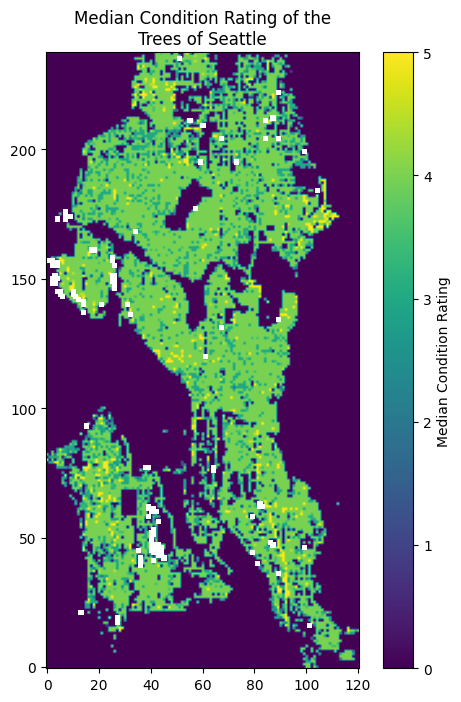

In [19]:
x_min, x_max = dftrees['x'].min().item(), dftrees['x'].max().item()
y_min, y_max = dftrees['y'].min().item(), dftrees['y'].max().item()

x_extent = x_max - x_min
y_extent = y_max - y_min

n_bins_horizontal = 120
bin_dim = x_extent / n_bins_horizontal  # feet per bin

print((x_min, x_max), (y_min, y_max), bin_dim)

dfbins = dftrees.copy()
dfbins['xbin'] = np.floor(((dfbins['x'] - x_min) / bin_dim)).astype(np.int64)
dfbins['ybin'] = np.floor(((dfbins['y'] - y_min) / bin_dim)).astype(np.int64)

heatmap_data = dfbins.groupby(['ybin', 'xbin'])['conditionrating'].median().unstack(fill_value=0)

plt.figure(figsize=(6, 8))
plt.imshow(heatmap_data, origin='lower', cmap='viridis')

# Add labels
plt.colorbar(label='Median Condition Rating')
plt.title('Median Condition Rating of the\nTrees of Seattle')

plt.show()

(1249044.03202781, 1293142.52717696) (184160.826480627, 271491.940426052) 367.4874595762483


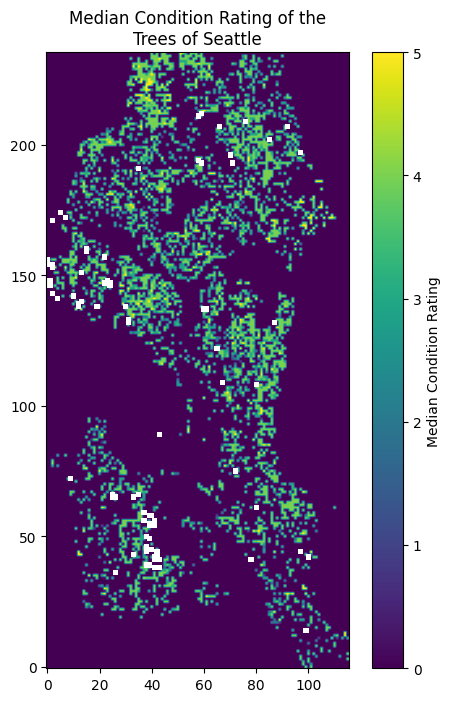

In [20]:
x_min, x_max = dftrees['x'].min().item(), dftrees['x'].max().item()
y_min, y_max = dftrees['y'].min().item(), dftrees['y'].max().item()

x_extent = x_max - x_min
y_extent = y_max - y_min

n_bins_horizontal = 120
bin_dim = x_extent / n_bins_horizontal  # feet per bin

print((x_min, x_max), (y_min, y_max), bin_dim)

dfbins = dftrees_ind.copy()
dfbins['xbin'] = np.floor(((dfbins['x'] - x_min) / bin_dim)).astype(np.int64)
dfbins['ybin'] = np.floor(((dfbins['y'] - y_min) / bin_dim)).astype(np.int64)

heatmap_data = dfbins.groupby(['ybin', 'xbin'])['conditionrating'].median().unstack(fill_value=0)

plt.figure(figsize=(6, 8))
plt.imshow(heatmap_data, origin='lower', cmap='viridis')

# Add labels
plt.colorbar(label='Median Condition Rating')
plt.title('Median Condition Rating of the\nTrees of Seattle')

plt.show()

    objectid      scientificname  genus  local  indigenous  conditionrating  \
39  72121645  Tsuga heterophylla  Tsuga   True        True              3.0   

               x              y  
39  1.264776e+06  269535.000072  
(np.float64(1260195.95952722), np.float64(1272991.00018032)) (np.float64(260079.999998361), np.float64(271491.940426052)) 85.3002710206667


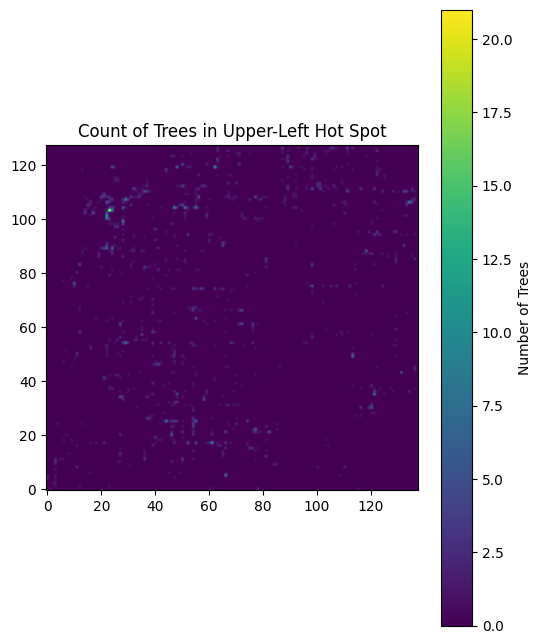

In [21]:
dfbins = dftrees_ind.copy()

dfbins = dfbins[dfbins['x'] >= 1.26e6]
dfbins = dfbins[dfbins['x'] <= 1.273e6]
dfbins = dfbins[dfbins['y'] >= 0.26e6]
dfbins = dfbins[dfbins['y'] <= 0.275e6]

"""
dfbins = dfbins[dfbins['x'] >= 1.2625e6]
dfbins = dfbins[dfbins['x'] <= 1.263e6]
dfbins = dfbins[dfbins['y'] >= 0.269e6]
dfbins = dfbins[dfbins['y'] <= 0.275e6]
"""

print(dfbins[:1])

x_min, x_max = dfbins['x'].min(), dfbins['x'].max()
y_min, y_max = dfbins['y'].min(), dfbins['y'].max()

x_extent = x_max - x_min
y_extent = y_max - y_min

n_bins_horizontal = 150
bin_dim = x_extent / n_bins_horizontal  # feet per bin

print((x_min, x_max), (y_min, y_max), bin_dim)

dfbins['xbin'] = np.floor(((dfbins['x'] - x_min) / bin_dim)).astype(np.int64)
dfbins['ybin'] = np.floor(((dfbins['y'] - y_min) / bin_dim)).astype(np.int64)

heatmap_data = dfbins.groupby(['ybin', 'xbin']).size().unstack(fill_value=0)

plt.figure(figsize=(6, 8))
plt.imshow(heatmap_data, origin='lower', cmap='viridis')

# Add labels
plt.colorbar(label='Number of Trees')
plt.title('Count of Trees in Upper-Left Hot Spot')

plt.show()

    objectid      scientificname  genus  local  indigenous  conditionrating  \
39  72121645  Tsuga heterophylla  Tsuga   True        True              3.0   

               x              y  
39  1.264776e+06  269535.000072  
(np.float64(1260195.95952722), np.float64(1272991.00018032)) (np.float64(260079.999998361), np.float64(271491.940426052)) 85.3002710206667


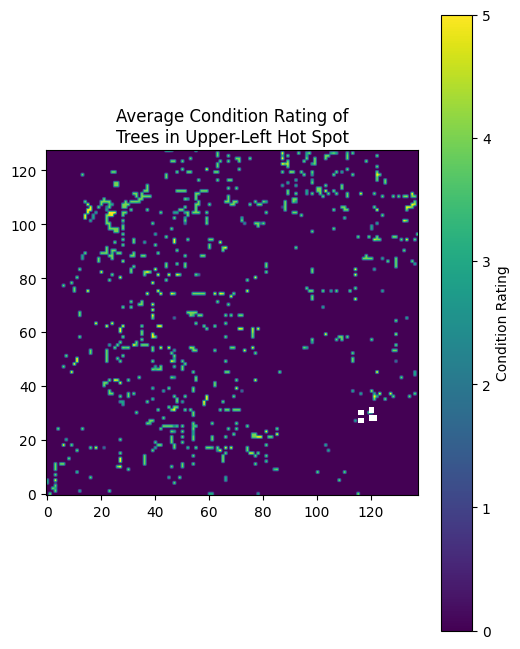

In [22]:
dfbins = dftrees_ind.copy()

dfbins = dfbins[dfbins['x'] >= 1.26e6]
dfbins = dfbins[dfbins['x'] <= 1.273e6]
dfbins = dfbins[dfbins['y'] >= 0.26e6]
dfbins = dfbins[dfbins['y'] <= 0.275e6]

"""
dfbins = dfbins[dfbins['x'] >= 1.2625e6]
dfbins = dfbins[dfbins['x'] <= 1.263e6]
dfbins = dfbins[dfbins['y'] >= 0.269e6]
dfbins = dfbins[dfbins['y'] <= 0.275e6]
"""

print(dfbins[:1])

x_min, x_max = dfbins['x'].min(), dfbins['x'].max()
y_min, y_max = dfbins['y'].min(), dfbins['y'].max()

x_extent = x_max - x_min
y_extent = y_max - y_min

n_bins_horizontal = 150
bin_dim = x_extent / n_bins_horizontal  # feet per bin

print((x_min, x_max), (y_min, y_max), bin_dim)

dfbins['xbin'] = np.floor(((dfbins['x'] - x_min) / bin_dim)).astype(np.int64)
dfbins['ybin'] = np.floor(((dfbins['y'] - y_min) / bin_dim)).astype(np.int64)

heatmap_data = dfbins.groupby(['ybin', 'xbin'])['conditionrating'].mean().unstack(fill_value=0)

plt.figure(figsize=(6, 8))
plt.imshow(heatmap_data, origin='lower', cmap='viridis')

# Add labels
plt.colorbar(label='Condition Rating')
plt.title('Average Condition Rating of\nTrees in Upper-Left Hot Spot')

plt.show()